# Importing packages

In [1]:
import os
import pickle
import warnings
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf

## Downsamlping and converting mp3 to wav format 

In [2]:
wavFile = 'input/Audio.ogg'
wav,_ = librosa.load(wavFile,sr=16000)

In [3]:
sf.write('input/Audio.wav', wav, 16000, 'PCM_16')

а) Сегментация (с использованием VAD): Используя librosa.feature.rms, мы вычисляем краткосрочную энергию. Модуль VAD представляет собой гибрид детектора на основе энергии и декодера на основе модели. На первом этапе детектор на основе энергии находит все сегменты с низкой энергией, применяя минимальную продолжительность сегмента. Порог энергии устанавливается автоматически для получения достаточного количества неречевых сегментов.

b) Извлечение векторов признаков и обучение GMM: с помощью librosa.feature.mfcc мы вычисляем кепстральные коэффициенты частоты Mel (MFCC) и их первую и вторую производные и комбинируем их следующим образом:

Обучение ГММ :

Модель смеси Гаусса (GMM) использует подход максимизации ожидания, который качественно делает следующее:

Выберите начальные предположения о местоположении и форме
Повторяйте до тех пор, пока не сойдется:
E-шаг : для каждой точки найдите веса, кодирующие вероятность членства в каждом кластере
M-шаг : для каждого кластера обновите его местоположение, нормализуйте веса и кодирование формы на основе всех точек данных, используя веса
Результатом этого является то, что каждый кластер связан не со сферой с жесткими краями, а с гладкой гауссовой моделью.

Следующий шаг, чтобы узнать, сколько оптимального количества компонентов нам нужно для данного аудиофайла для обучения GMM.

### wavFile - Audio file path
### vad- voice activity decisions at frame level please refer vad.py gist 

In [5]:
segLen,frameRate,numMix = 3,50,128
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(y=wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [5]:
# ste = librosa.feature.rms(y=wavData,hop_length=int(16000/frameRate)).T

In [6]:
#y,sr = librosa.load(wavFile)

In [7]:
# %run -i "vad.py"
# import vad

In [6]:
sr = 16000
hop_length = 30

In [9]:
# wavData

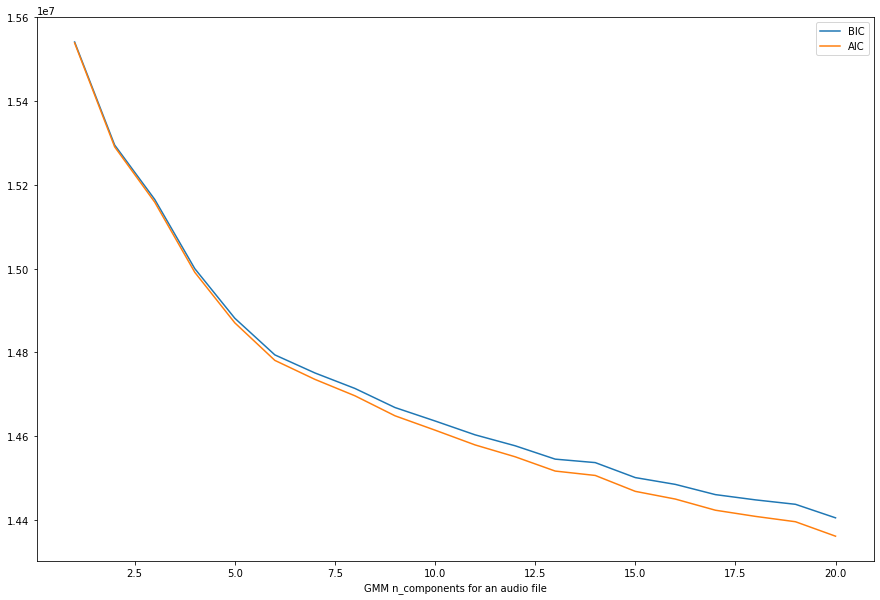

In [7]:
#wavFile - Audio file path
wavData,_ = librosa.load(wavFile, sr=16000)
vad = VoiceActivityDetection(wavData,frameRate)
mfcc = librosa.feature.mfcc(y=wavData, sr=sr, n_mfcc=20, hop_length = hop_length).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

Оптимальное количество кластеров — это значение, которое минимизирует AIC или BIC, в зависимости от того, какое приближение мы хотим использовать. поэтому AIC и BIC говорят нам, что 20 или более компонентов будут лучшим выбором.
Обратите внимание, что этот выбор числа компонентов измеряет, насколько хорошо GMM работает как средство оценки плотности , а не как хорошо он работает как алгоритм кластеризации .

Теперь следующим шагом будет запись функции для обучения GMM.

In [8]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(y=wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")
    return np.asarray(segLikes)

wavFile: полный путь к аудиофайлу.
frameRate: количество кадров в секунду
, я взял 50 кадров в секунду
.
numMix: количество смеси в модели смеси. Я установил numMix на 128, изучив битрейт в секунду.

Функции GMM возвращают массив предсказанной вероятности на основе сегмента.

C) Обрамление кластеризации и сегментации:

Теперь на следующем этапе мы проведем кластерный анализ результатов GMM .
В текущем сценарии наша главная цель — настроить n_cluster , и мы знаем, что у нас есть только 2 динамика, поэтому мы собираемся настроить его с помощью агломеративной кластеризации. Агломеративная кластеризация использует подход «снизу вверх», при котором каждое наблюдение начинается в своем собственном кластере, а пары кластеров объединяются по мере продвижения вверх по иерархии.
Перед кластерным анализом мы выполняем масштабирование и нормализацию данных, чтобы все функции стали сопоставимыми, а данные приблизительно соответствовали распределению Гаусса.

In [9]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [14]:
clusterset = trainGMM(wavFile, frameRate, segLen, vad, numMix)

scaler = StandardScaler()
# Scaling the data so that all the features become comparable
X_scaled = scaler.fit_transform(clusterset)
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = sklearn.preprocessing.normalize(X_scaled)
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust = cluster.fit_predict(X_normalized)

Training GMM..
Training Done


In [15]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])
frameClust
vad

array([ True,  True,  True, ..., False, False, False])

Сегментация: после выполнения кластеризации мы получаем значение гипотезы говорящего на уровне сегмента, теперь следующим шагом является преобразование сегмента в уровень кадра. Для этого используйте функцию ниже.

In [19]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal
  
pass1hyp = -1*np.ones(len(vad))
pass1hyp
# pass1hyp[vad] = frameClust
#pass1hyp[-1*np.ones(len(vad))] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, wavFile)

AttributeError: 'numpy.ndarray' object has no attribute 'pass1hup'